# Weather analysis - French coast

This notebook aims at highlighting interesting statistics about weather in famous places along the French coasts.

The historical data comes from this Russian [website](https://rp5.ru/Weather_in_France), and corresponds to meteorological stations in French coastal airports, which are part of the METAR meterological network (list of French METAR stations available [here](https://fr.allmetsat.com/metar-taf/france.php?icao=LFRZ)).

In [4]:
import pandas as pd
import numpy as np
import datetime
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from shapely.geometry import Point
import seaborn as sns
from PIL import Image
from collections import OrderedDict
import plotly.express as px

## Meteo

### Preprocessing

In [5]:
# variables to rename
variables = {'year':'year',
             'month':'month',
             'day':'day',
             'hour':'hour',
             'WW':'comments',
             'T':'temp',
             'Po':'pressure',
             'U':'humid',
             'Ff':'windspeed',
             'VV':'visib',
             'N':'cloudcover',
             'H':'cloudsheight',
             'RRR':'precip',
            }

In [6]:
# strings to replace with values
replacements = {'Trace of precipitation':0.1,
                'No precipitation':0,
                '100%.':100,
                '90  or more, but not 100%':90,
                '70 – 80%.':75,
                '60%.':60,
                '50%.':50,
                '40%.':40,
                '20–30%.':25,
                'no clouds':0,
                '10%  or less, but not 0':5,
                'Sky obscured by fog and/or other meteorological phenomena.':100,
                '2500 or more, or no clouds.':0,
                '2000-2500':2250,
                '1500-2000':1750,
                '1000-1500':1250,
                '600-1000':800,
                '300-600':450,
                '200-300':250,
                '100-200':150,
                '50-100':100,
                'Less than  50':50,
                'less than 0.1':50
               }

In [7]:
def round_to_nearest_k(x, k):
    return int(k * round(float(x)/k))

In [8]:
def preprocess(city_name):
    
    # concatenate all files related to city_name
    city_data = []
    for file in glob.glob('Data/{}/20*.xls'.format(city_name)):
        df = pd.read_excel(file, header=6)
        df = df.iloc[::-1] # reverse order of rows to be chronological
        city_data.append(df) # store dataframe in a list
    df = pd.concat(city_data, ignore_index=True)

    # datetime transformations
    df.rename(columns={df.columns[0]: "time"}, inplace = True)
    df.time = pd.to_datetime(df.time)
    df['year'] = df.time.dt.year
    df['month'] = df.time.dt.month
    df['day'] = df.time.dt.day
    df['hour'] = df.time.dt.hour
    df.drop(columns=['time'], inplace=True)

    # select the hours we want
    hours_1 = df['hour'] >= 9
    hours_2 = df['hour'] <= 21
    df = df[hours_1 & hours_2]

    # select the variables we want
    df = df[variables.keys()]
    df.rename(columns=variables, inplace=True)
    df.reset_index(drop=True, inplace=True)

    # replace string comments with numbers
    df.replace(to_replace=replacements, inplace=True)
    df.replace(to_replace='Cloud development not observed or not observable. ', value=' ', inplace=True)

    # fill in missing values with linear interpolation
    to_interpolate = df.columns[-8:] 
    df[to_interpolate] = df[to_interpolate].apply(pd.to_numeric)
    df[to_interpolate] = df[to_interpolate].interpolate(method='linear', limit=None)
    df[to_interpolate] = df[to_interpolate].fillna(method='bfill', limit=None) # in case nan is the first index
    df[to_interpolate] = df[to_interpolate].fillna(method='ffill', limit=None) # in case nan is the last index

    # round values
    df = df.round(1)
    df.visib = df.visib.round(0)
    df.cloudcover = df.cloudcover.apply(lambda x: round_to_nearest_k(x, k=5))
    df.cloudsheight = df.cloudsheight.apply(lambda x: round_to_nearest_k(x, k=50))
    
    # add boolean indicators
    df['precip_hours'] = df['precip'].mask(cond=df['precip']>0, other=1)
    
    return df

In [17]:
df = preprocess('Biarritz')
print(df.shape)
df.head(20)

(28398, 14)


,year,month,day,hour,comments,temp,pressure,humid,windspeed,visib,cloudcover,cloudsheight,precip,precip_bool
0,2014,1,1,9,,11.9,752.8,61.0,4.0,60.0,40,1750,0.0,0.0
1,2014,1,1,10,,12.8,752.7,56.0,4.0,60.0,90,0,0.0,0.0
2,2014,1,1,11,,13.3,752.5,55.0,5.0,60.0,90,0,0.0,0.0
3,2014,1,1,12,,14.0,752.5,53.0,4.0,60.0,90,0,0.0,0.0
4,2014,1,1,13,,14.8,751.9,51.0,4.0,60.0,90,0,0.0,0.0
5,2014,1,1,14,,15.0,751.3,51.0,5.0,55.0,90,0,0.0,0.0
6,2014,1,1,15,"Rain, not freezing, intermittent, slight at ti...",12.9,750.6,66.0,5.0,13.0,90,2250,0.6,1.0
7,2014,1,1,16,Rain (not freezing) not falling as shower(s).,13.9,749.8,60.0,5.0,60.0,90,2250,0.6,1.0
8,2014,1,1,17,,14.3,749.5,59.0,5.0,60.0,90,2250,0.0,0.0
9,2014,1,1,18,,14.5,748.9,57.0,5.0,60.0,90,2250,0.0,0.0


In [29]:
# check missing values
df.isna().sum()

year            0
month           0
day             0
hour            0
comments        0
temp            0
pressure        0
humid           0
windspeed       0
visib           0
cloudcover      0
cloudsheight    0
precip          0
precip_bool     0
dtype: int64

In [30]:
# check values for one of the variables
x = df.visib.unique()
x = np.sort(x)
x

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 65., 70., 71.])

### Analysis

#### Precipitations

* Bar plot: cumulated precipitations

Single city:

In [40]:
sns.set_palette('GnBu')
plt.style.use('seaborn-dark')

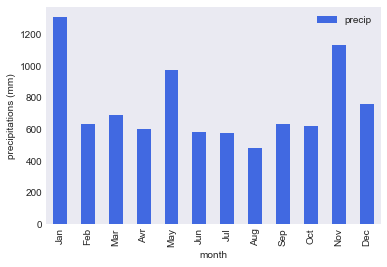

In [56]:
df.groupby(df['month']).sum().filter(items=['precip']).plot(kind='bar', color='royalblue')
plt.xticks(np.arange(0,12, step=1), ['Jan','Feb','Mar','Avr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.ylabel('precipitations (mm)');

All cities stacked next to each other:

In [11]:
cities = ['Biarritz',
          'Arcachon',
          'Deauville',
          'Dinard',
          'Hyères',
          'Lorient',
          'Nazaire',
          'Nice',
          'Rochelle',
          'Touquet',
          'Agde',
          'Ajaccio']

months = ['Jan','Feb','Mar','Avr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [21]:
# Build dict for plotting (long computations!)
dict_cumprecip = {}
for city in cities:
    df = preprocess(city)
    dict_cumprecip[city] = [round(val,1) for array in df.groupby(df['month']).sum().filter(items=['precip']).values/6 for val in array]
dict_cumprecip

# Order dict
dict_cumprecip = OrderedDict(sorted(dict_cumprecip.items(), key=lambda x: sum(x[1]), reverse=True))
dict_cumprecip

OrderedDict([('Biarritz',
              [217.7,
               105.3,
               114.6,
               100.2,
               162.5,
               96.6,
               95.6,
               80.1,
               105.2,
               103.4,
               188.8,
               126.2]),
             ('Lorient',
              [121.9,
               67.1,
               63.6,
               64.3,
               67.6,
               58.3,
               65.1,
               56.5,
               66.2,
               90.6,
               78.7,
               124.6]),
             ('Touquet',
              [80.0,
               63.4,
               47.5,
               54.7,
               69.1,
               46.9,
               62.8,
               80.5,
               117.4,
               86.6,
               102.4,
               95.8]),
             ('Deauville',
              [89.4,
               58.0,
               64.8,
               79.8,
               71.0,
               71

In [22]:
def multiple_barplot(ax, data, colors=None, total_width=0.8, single_width=0.9, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax: matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors: array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width: float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

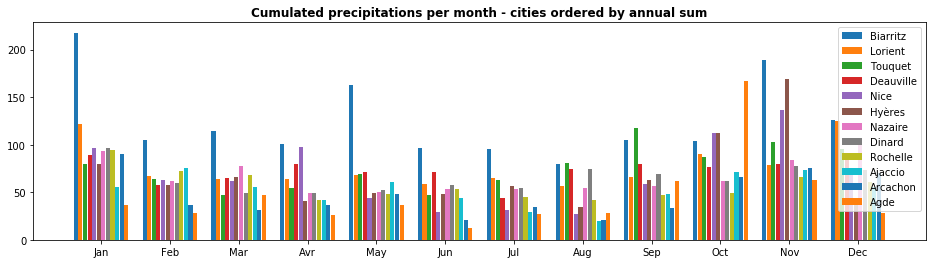

In [23]:
fig, ax = plt.subplots(figsize=(16,4))
multiple_barplot(ax, dict_cumprecip, total_width=.8, single_width=.9)
plt.xticks(np.arange(0,12, step=1), months)
plt.title("Cumulated precipitations per month - cities ordered by annual sum", fontweight='semibold')
plt.show()

* Stackplot: comparison of all cities' cumulated precipitations

In [67]:
df_cumprecip = pd.DataFrame.from_dict(dict_cumprecip).transpose()
df_cumprecip.columns = months
df_cumprecip

,Jan,Feb,Mar,Avr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Biarritz,1306.1,631.8,687.6,601.4,974.8,579.5,573.5,480.4,631.2,620.6,1132.8,757.3
Lorient,731.4,402.7,381.5,385.9,405.8,349.9,390.8,338.8,397.1,543.7,472.4,747.4
Touquet,480.1,380.6,285.3,328.3,414.4,281.1,376.6,483.1,704.6,519.7,614.1,575.0
Deauville,536.4,348.0,389.0,478.7,426.1,426.4,266.0,445.2,477.1,458.6,479.1,539.4
Nice,581.7,379.9,371.6,582.7,264.5,178.5,185.9,163.7,353.8,670.9,820.1,437.5
Hyères,479.9,344.9,394.9,243.3,293.2,291.2,336.3,204.8,375.9,674.8,1014.1,240.9
Nazaire,557.2,370.0,465.0,293.2,302.8,323.0,319.1,326.1,338.0,373.1,502.6,614.5
Dinard,578.1,360.4,297.4,292.2,311.9,345.8,325.5,447.7,412.2,371.1,463.2,441.2
Rochelle,568.9,436.0,409.4,248.2,289.3,318.2,272.1,250.1,283.7,295.4,399.0,362.7
Ajaccio,331.8,451.6,333.7,249.6,366.8,262.1,176.0,120.0,291.4,428.5,441.2,331.8


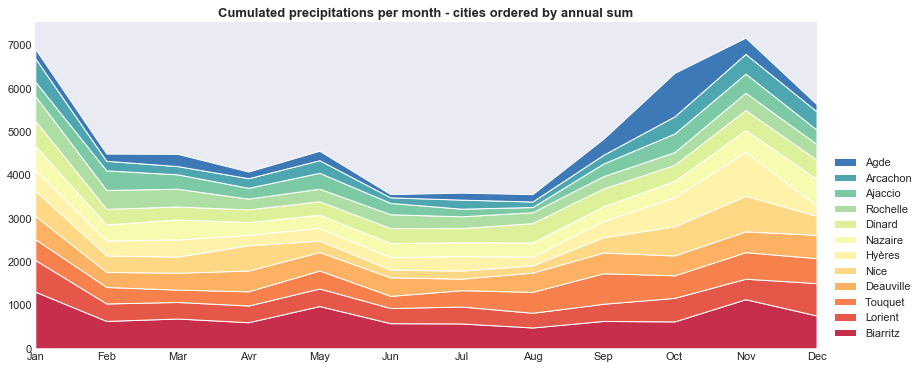

In [96]:
# plot and style stackplot

labels = np.asarray(df_cumprecip.index)
xticks = months

sns.set(style="white")
plt.style.use('seaborn-dark') # I use both styles to have black background but white lines
sns.set_palette("Spectral",12)
fig, ax = plt.subplots(figsize=(14,6))
ax.stackplot(range(0,12), df_cumprecip, labels = labels)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='lower left', bbox_to_anchor= (1.01,0.0), fontsize=11)
plt.xlim(0, 11)
plt.xticks(np.arange(0, 12, step=1), xticks)
plt.title("Cumulated precipitations per month - cities ordered by annual sum", fontweight="semibold", fontsize=13)
plt.show()

* Static bubble plot: nb of hours of precipitation (size of bubble) and mean cumulated precipitations (y-axis) for the summer months

In [145]:
# Build dict including precip_hours

dict_preciphours = {}
for city in cities:
    df = preprocess(city)
    
    # select only summer months
    summer_1 = df['month'] >= 6
    summer_2 = df['month'] <= 8
    df = df[summer_1 & summer_2]
    
    dict_preciphours[city] = round(np.mean([array[0] for array in df.groupby(df['month']).sum().filter(items=['precip', 'precip_hours']).values/6]),1), round(np.mean([array[1] for array in df.groupby(df['month']).sum().filter(items=['precip', 'precip_hours']).values/6]),1)

# Order dict
dict_preciphours = OrderedDict(sorted(dict_precipbool.items(), key=lambda x: x[1][1], reverse=True))
dict_preciphours

OrderedDict([('Lorient', (60.0, 68.8)),
             ('Touquet', (63.4, 65.9)),
             ('Dinard', (62.2, 65.5)),
             ('Deauville', (63.2, 65.1)),
             ('Biarritz', (90.7, 64.8)),
             ('Nazaire', (53.8, 63.7)),
             ('Rochelle', (46.7, 50.8)),
             ('Arcachon', (25.8, 28.9)),
             ('Nice', (29.3, 24.6)),
             ('Ajaccio', (31.0, 22.9)),
             ('Agde', (22.6, 21.0)),
             ('Hyères', (46.2, 19.7))])

In [146]:
# Convert to dataframe
df_precipbool = pd.DataFrame.from_dict(dict_precipbool).transpose()
df_precipbool = df_precipbool.reset_index()
df_precipbool.columns = ['city','precip_cumul_per_summermonth','precip_hours_per_summermonth']
df_precipbool

,city,precip_cumul_per_summermonth,precip_hours_per_summermonth
0,Lorient,60.0,68.8
1,Touquet,63.4,65.9
2,Dinard,62.2,65.5
3,Deauville,63.2,65.1
4,Biarritz,90.7,64.8
5,Nazaire,53.8,63.7
6,Rochelle,46.7,50.8
7,Arcachon,25.8,28.9
8,Nice,29.3,24.6
9,Ajaccio,31.0,22.9


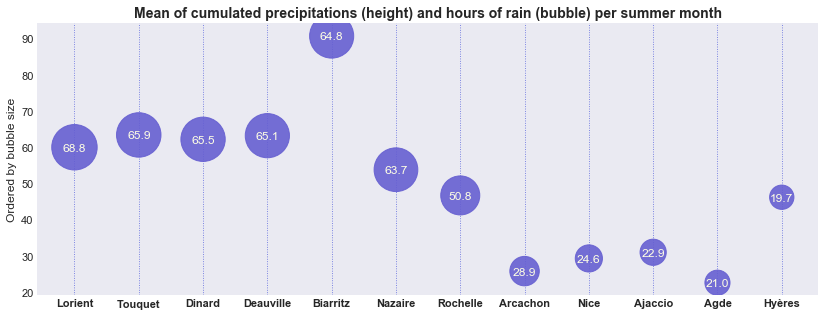

In [148]:
plt.style.use('seaborn-dark')
fig, ax = plt.subplots(figsize=(14,5))
xrange = range(len(df_precipbool['city']))
# equivalent to np.arange(len(df_precipbool['city']))
# and to range(0,df_precipbool.shape[0])

plt.scatter(x=xrange, y=df_precipbool['precip_cumul_per_summermonth'], s=df_precipbool['precip_hours_per_summermonth']*30,
            c='xkcd:dark periwinkle', alpha=0.9)
# equivalent to ax = sns.scatterplot(same)

plt.xticks(np.arange(0, 12, step=1))
ax.set_xticklabels(df_precipbool['city'], fontweight='semibold')
plt.ylabel("Ordered by bubble size")
plt.title('Mean of cumulated precipitations (height) and hours of rain (bubble) per summer month', fontweight='bold', fontsize = '14')
plt.grid(True, axis = 'x', color='xkcd:warm blue', linestyle=':', linewidth=0.9, alpha=0.8)

for line in range(0,df_precipbool.shape[0]):
     ax.text(xrange[line], df_precipbool.precip_cumul_per_summermonth[line]-1, df_precipbool.precip_hours_per_summermonth[line], 
             horizontalalignment='center', size='medium', color='xkcd:off white', weight='normal')
# works as well with df_precipbool.sum_x.iloc[line] and df_precipbool.sum_y.iloc[line]

plt.show()

#### Precipitations and temperature, animated

* Animated bubble plot:

In [9]:
coasts = {'Biarritz':'Pays Basque',
           'Arcachon':'Landes',
           'Deauville':'Nord',
           'Dinard':'Bretagne',
           'Hyères':"Sud",
           'Lorient':'Bretagne',
           'Nazaire':'Bretagne',
           'Nice':"Sud",
           'Rochelle':'Bretagne',
           'Touquet':"Nord",
           'Agde':"Sud",
           'Ajaccio':"Sud"
          }

The `Grouper` class has the big advantage over datetime to not group months over several years.

In [17]:
frames = []
i = 1

for city in cities:
    
    # load relevant data
    df = preprocess(city)
    summer_1 = df['month'] >= 6
    summer_2 = df['month'] <= 8
    df = df[summer_1 & summer_2]
    df = df[['year','month','day','precip','precip_hours','temp']]    
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
    # if we didn't have the day we could assign it:
    # df['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
    df = df.drop(columns=['year', 'month', 'day'])
    
    # perform groupings
    df2 = df[['date','precip_hours','precip']].groupby(pd.Grouper(key='date', freq='M')).sum()
    df3 = df[['date','temp']].groupby(pd.Grouper(key='date', freq='M')).mean()
    df = df2.merge(df3, on='date', how='outer')
    #df = df.groupby(pd.Grouper(key='date', freq='Y')).mean()
    df.reset_index(inplace=True)
    
    # additional preprocessing
    df['year'] = df.date.dt.year
    df[['temp','precip_hours','precip']] = df[['temp','precip_hours','precip']].apply(lambda x: round(x,1))
    df['date'] = df['date'].apply(lambda x: str(x))
    df['date'] = df['date'].apply(lambda x: x[:-12])
    df = df[df['precip'] != 0] # remove empty rows created by Grouper
    
    # add coast, city and id columns
    df['coast'] = df['year']
    df['city'] = df['year']
    df['id'] = df['year']
    df['city'] = df['city'].apply(lambda x: city)
    df['coast'] = df['coast'].apply(lambda x: coasts[city])
    df['id'] = df['id'].apply(lambda x: i)
    i = i+1
    
    frames.append(df)

In [18]:
result = pd.concat(frames)
result

,date,precip_hours,precip,temp,year,coast,city,id
0,2014-06,45.0,79.0,20.0,2014,Pays Basque,Biarritz,1
1,2014-07,52.0,67.7,20.5,2014,Pays Basque,Biarritz,1
2,2014-08,76.0,71.2,19.4,2014,Pays Basque,Biarritz,1
12,2015-06,46.0,88.6,19.1,2015,Pays Basque,Biarritz,1
13,2015-07,55.0,27.5,20.3,2015,Pays Basque,Biarritz,1
...,...,...,...,...,...,...,...,...
49,2018-07,24.0,92.7,24.9,2018,Sud,Ajaccio,12
50,2018-08,30.0,11.5,24.3,2018,Sud,Ajaccio,12
60,2019-06,21.0,34.0,23.4,2019,Sud,Ajaccio,12
61,2019-07,18.0,14.9,24.3,2019,Sud,Ajaccio,12


In [32]:
fig = px.scatter(result, x="temp", y="precip", animation_frame="date", animation_group="city",
                 size="precip_hours", color="coast", hover_name="city", 
                 title='Evolution of precipitations and temperature, 2014-2019',
                 size_max=40, range_x=[11,27], range_y=[-5,170])
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1000
fig.show()

We can easily run any plotly figure in a dash app environment:

In [34]:
import dash
import dash_core_components as dcc
import dash_html_components as html

app = dash.Dash()
app.layout = html.Div([
    dcc.Graph(figure=fig)
])

app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter

Running on http://127.0.0.1:8050/
Debugger PIN: 198-113-989
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


#### Temperature

Below are examples, to be adapted:

In [ ]:
# Animated bar chart
df = px.data.gapminder()

fig = px.bar(df, x="continent", y="pop", color="continent",
  animation_frame="year", animation_group="country", range_y=[0,4000000000])
fig.show()

In [ ]:
# Simple plotly line chart
df = px.data.gapminder().query("continent != 'Asia'") # remove Asia for visibility
fig = px.line(df, x="year", y="lifeExp", color="continent",
              line_group="country", hover_name="country")
fig.show()

## Coordinates plotting

I obtained coordinates (DMS format, convertible to DD with this [tool](https://www.latlong.net/degrees-minutes-seconds-to-decimal-degrees)) of METAR stations through this [website](https://www.aviationweather.gov/docs/metar/stations.txt).

In [10]:
coordinates = {'Biarritz':(43.47, -1.52),
               'Arcachon':(44.52, -1.12),
               'Deauville':(49.37, 0.15),
               'Dinard':(48.58, -2.07),
               'Hyères':(43.10, 6.15),
               'Lorient':(47.77, -3.45),
               'St-Nazaire':(47.32, -2.17),
               'Nice':(43.63, 7.20),
               'La Rochelle':(46.18, -1.20),
               'Le Touquet':(50.52, 1.62),
               'Agde':(43.32,3.35),
               'Ajaccio':(41.92,8.80)
              }

In [11]:
# Convert to geo dataframe
coordinates = pd.DataFrame(coordinates).T
coordinates.columns = ['lat', 'lon']
coordinates['geometry'] = list(zip(coordinates['lon'], coordinates['lat']))
coordinates['geometry'] = coordinates['geometry'].apply(lambda x: Point(x))
coordinates = gpd.GeoDataFrame(coordinates, crs={'init': 'epsg:4326'}) # WSG84
coordinates.head(3)

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,lat,lon,geometry
Biarritz,43.47,-1.52,POINT (-1.52000 43.47000)
Arcachon,44.52,-1.12,POINT (-1.12000 44.52000)
Deauville,49.37,0.15,POINT (0.15000 49.37000)


In [12]:
# Grab FR outline
fr_outline = gpd.read_file('/Users/Thomas/Documents/Data Science X/Stage/Total/Solar Panels/Data/OSM_coord/FRA_adm/FRA_adm2.shp')

In [13]:
# Change CRS for nicer display
coordinates = coordinates.to_crs(epsg=27700)
fr_outline = fr_outline.to_crs(epsg=27700)

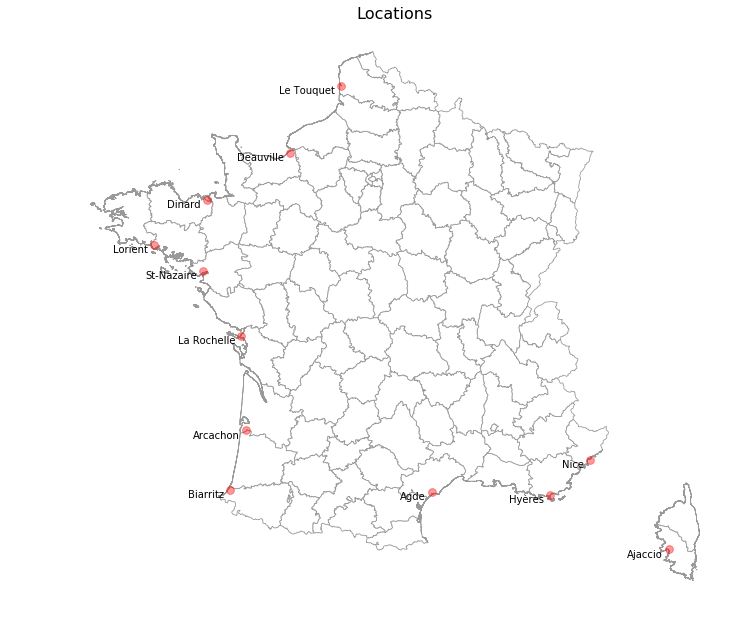

In [14]:
# Plot
fig, ax = plt.subplots(1, figsize=(12, 12))
fr_outline.plot(ax=ax, color='white', linewidth=0.8, edgecolor='0.6')
coordinates.plot(ax=ax, markersize=60, color='red', alpha=0.4)

for x, y, label in zip(coordinates.geometry.x, coordinates.geometry.y, coordinates.index):
    ax.annotate(label, xy=(x, y), xytext=(-6, -8), horizontalalignment='right', textcoords="offset points")

ax.set_title("Locations", fontdict={'fontsize':'16', 'fontweight' :'4'})
ax.axis('off')
plt.show();

## Sea Surface Temperature

One of the most famous and comprehensive dataset for Sea Surface Temperature (SST) is the ERSST dataset, collected by the NOAA and available through this [link](https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v5). The problem is it comes in ASCII or NetCDF gridded data format, which is not easy to manipulate with python. As a consequence, I used directly computed temperature means and history per location through the [seatemperature.info](https://seatemperature.info/july/france-water-temperature.html) website.

In [4]:
def slice_temp(x): # function to remove the "°C"
    return x[:1] if len(x)<4 else x[:2]

In [5]:
sst = pd.read_excel('Data/SST.xlsx', header=1, index_col=0)
sst = sst.applymap(lambda x: slice_temp(x))
sst = sst.applymap(lambda x: int(x))
sst = sst.reindex(sst.sum().sort_values().index, axis=1) # reorder by summed temp over the year
sst

,Touquet,Deauville,Dinard,Nazaire,Lorient,Rochelle,Arcachon,Biarritz,Agde,Hyères,Ajaccio,Nice
Jan,8,8,9,9,10,10,12,12,12,14,14,14
Feb,7,7,8,9,10,9,11,12,11,14,13,14
Mar,7,8,8,10,10,10,11,12,12,13,14,14
Apr,9,10,10,12,11,12,13,14,14,14,15,15
May,12,13,12,14,13,15,15,15,16,16,17,17
June,15,15,15,16,16,18,18,19,19,20,21,21
July,17,18,17,18,18,20,20,21,21,23,24,24
Aug,18,19,18,19,18,20,21,22,22,24,25,25
Sept,17,18,18,17,17,19,20,21,20,22,23,23
Oct,16,16,16,16,16,17,18,18,19,20,21,21


#### Radar plot: average in the summer months

In [6]:
summer = sst[5:8]
summer_mean = summer.mean()
summer_mean = pd.DataFrame(summer_mean)
summer_mean.reset_index(inplace=True)
summer_mean.rename(columns = {summer_mean.columns[0]:'city', summer_mean.columns[1]:'mean'}, inplace=True)
summer_mean = summer_mean.sort_values(by='mean')
summer_mean

,city,mean
0,Touquet,16.666667
2,Dinard,16.666667
1,Deauville,17.333333
4,Lorient,17.333333
3,Nazaire,17.666667
5,Rochelle,19.333333
6,Arcachon,19.666667
7,Biarritz,20.666667
8,Agde,20.666667
9,Hyères,22.333333


In [7]:
labels = summer_mean['city'].values
stats = summer_mean['mean'].values

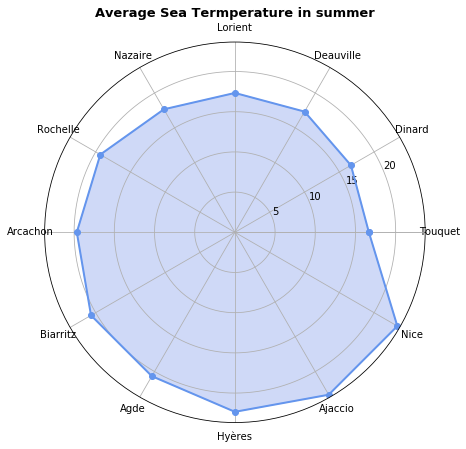

In [8]:
def spiderplot(labels, stats):
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    stats=np.concatenate((stats,[stats[0]]))
    angles=np.concatenate((angles,[angles[0]]))
    fig=plt.figure(figsize = (7,7))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-', linewidth=2, color='cornflowerblue')
    ax.fill(angles, stats, alpha=0.25, color = 'royalblue')
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.set_title('Average Sea Termperature in summer', fontweight="bold", fontsize = 13)
    ax.grid(True)
    return ax

spiderplot(labels, stats)
plt.show()

#### Line plot: comparison over the year

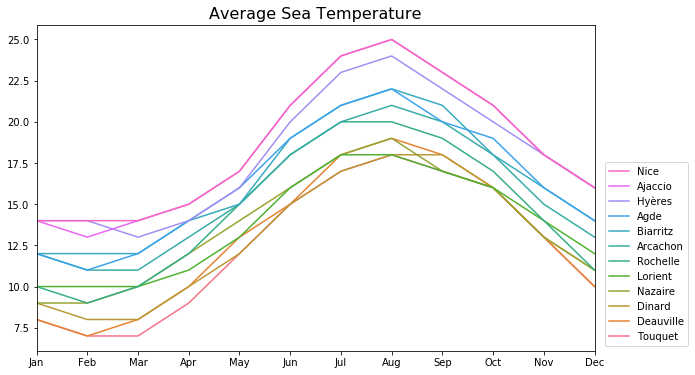

In [40]:
sst = sst.reset_index(drop=True)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
plt.xlim(0, 11)
plt.title('Average Sea Temperature',fontsize=16)
sns.lineplot(data=sst, dashes=False)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='lower left', bbox_to_anchor= (1.01,0.0))

ax.set_xticks(range(0,12))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.show()

Animated version:

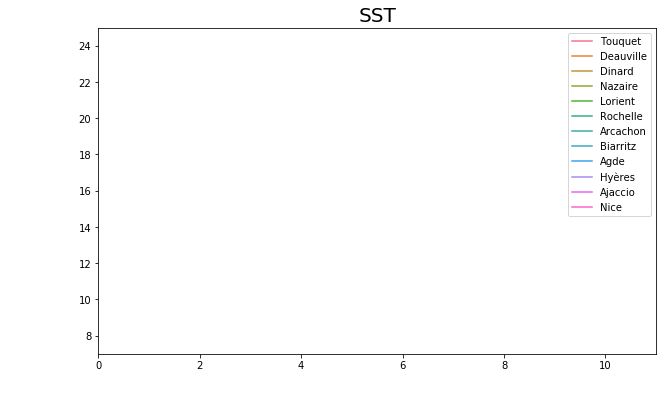

In [21]:
fig = plt.figure(figsize=(10,6))
plt.xlim(0, 11)
plt.ylim(sst.values.min(), sst.values.max())
plt.title('SST',fontsize=20)

def animate(i):
    data = sst.iloc[:int(i+1)] #select data range
    sns.lineplot(data=data, dashes=False)
    plt.legend

ani = animation.FuncAnimation(fig, animate, frames=12)
plt.show()

#FFwriter = animation.FFMpegWriter(fps=30)
#ani.save('Plots/line_animation.mp4', writer=FFwriter)

#### 3D plot

In [59]:
# Set num values for cities and months
sst.columns=["1","2","3","4","5","6","7","8","9","10","11","12"]
sst = sst.reset_index(drop=True)
sst

# we could have used the label encoding methods from pandas and scikit learn (see below)
# but they choose the label numbers in random order, what we don't want

#from sklearn.preprocessing import LabelEncoder
#lb_make = LabelEncoder()
#df["X"] = lb_make.fit_transform(df["X"])

#df['X']=pd.Categorical(df['X'])
#df['X']=df['X'].cat.codes

,1,2,3,4,5,6,7,8,9,10,11,12
0,8,8,9,9,10,10,12,12,12,14,14,14
1,7,7,8,9,9,10,11,11,12,13,14,14
2,7,8,8,10,10,10,11,12,12,14,13,14
3,9,10,10,12,12,11,13,14,14,15,14,15
4,12,13,12,14,15,13,15,16,15,17,16,17
5,15,15,15,16,18,16,18,19,19,21,20,21
6,17,18,17,18,20,18,20,21,21,24,23,24
7,18,19,18,19,20,18,21,22,22,25,24,25
8,17,18,18,17,19,17,20,20,21,23,22,23
9,16,16,16,16,17,16,18,19,18,21,20,21


In [60]:
# unstack dataframe so we have 1 point per row
df=sst.unstack().reset_index()
df.columns=["X","Y","Z"]
df = df.applymap(lambda x: int(x))
print(df.shape)
df.head()

(144, 3)


,X,Y,Z
0,1,0,8
1,1,1,7
2,1,2,7
3,1,3,9
4,1,4,12


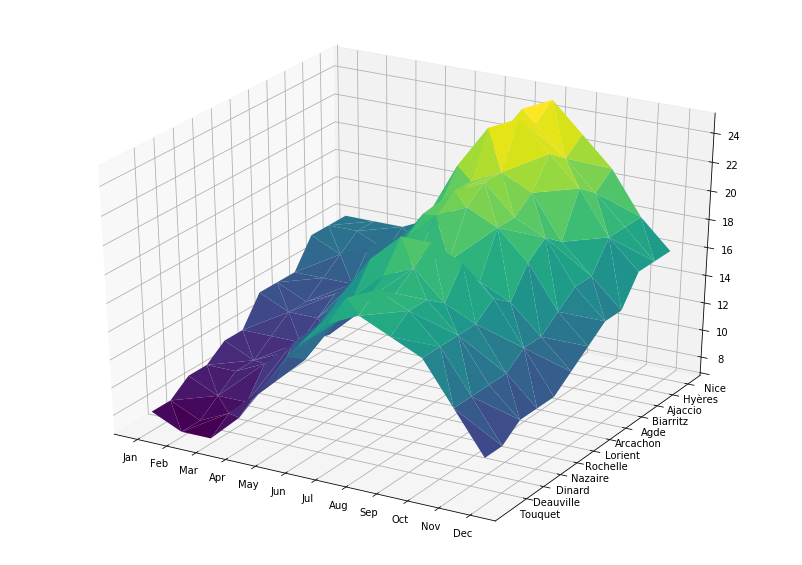

In [84]:
# Make the plot
fig = plt.figure(figsize=(14,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
ax.set_yticks(range(2,14))
ax.set_xticks(range(0,12))
ax.set_yticklabels(['Touquet', 'Deauville', 'Dinard', 'Nazaire', 'Rochelle', 'Lorient',
       'Arcachon', 'Agde', 'Biarritz', 'Ajaccio', 'Hyères', 'Nice'])
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

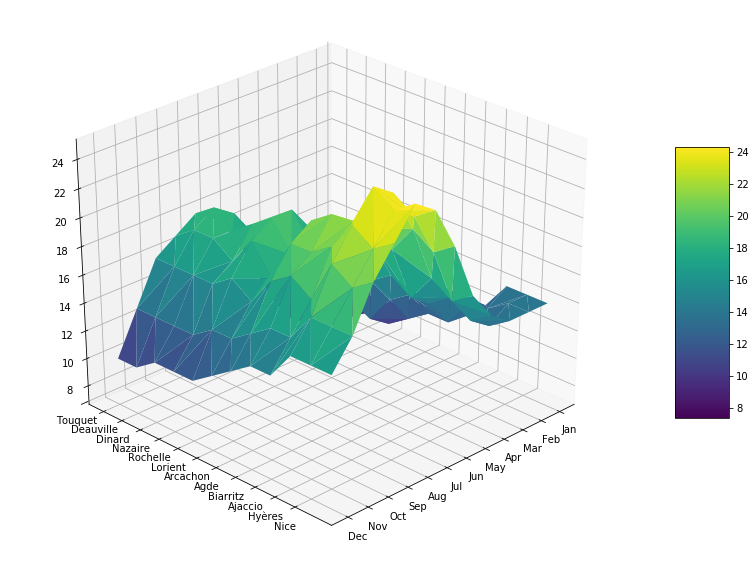

In [88]:
# Rotate it and add color bar
fig = plt.figure(figsize=(14,10))
ax = fig.gca(projection='3d')
surf=ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
ax.set_yticks(range(0,12))
ax.set_xticks(range(0,12))
ax.set_yticklabels(['Touquet', 'Deauville', 'Dinard', 'Nazaire', 'Rochelle', 'Lorient',
       'Arcachon', 'Agde', 'Biarritz', 'Ajaccio', 'Hyères', 'Nice'])
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.view_init(30, 45)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# it's also possible to use another palette with: cmap=plt.cm.jet

In [89]:
# To animate it, we are going to do 20 plots, for 20 different angles
for angle in range(70,210,2):
 
    # Make the plot
    fig = plt.figure(figsize=(14,10))
    ax = fig.gca(projection='3d')
    surf=ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
    ax.set_yticks(range(0,12))
    ax.set_xticks(range(0,12))
    ax.set_yticklabels(['Touquet', 'Deauville', 'Dinard', 'Nazaire', 'Rochelle', 'Lorient',
           'Arcachon', 'Agde', 'Biarritz', 'Ajaccio', 'Hyères', 'Nice'])
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.view_init(30, 45)

    # Set the angle of the camera
    ax.view_init(30,angle)

    # Save it
    filename='Animations/sst_animation/sst_step'+str(angle)+'.png'
    plt.savefig(filename, dpi=96)
    plt.gca()
    plt.close(fig) # do not display inline

Then either we use `image magick` in bash to transform all the png files into an GIF file:

> `convert -delay 10 sst*.png animated_sst.gif`

Or we use PIL:

In [92]:
# Create the frames
frames = []
imgs = glob.glob("Plots/sst_animation/*.png")
imgs.sort()
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('Plots/sst_animation_2.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=200, loop=0)

## Conclusion

Horizontal cumulated bar chart with comparison of main items for all cities

In [ ]:
# create a dictionary with for each theme the total nb of occurences of other themes

content = data[data.columns[-11:]]
dict_contents = {}

for col in content.columns:
    
    # first build a table with only rows for which col isn't null
    content = data[data.columns[-11:]]
    index = content[ content[col] == 0 ].index
    content.drop(index, inplace=True)
    content[col].values[:] = 0 # make sure to keep col, but with 0s only (for graph)
    
    # then count the sum of marks in each of the the remaining columns
    dict_col = [content[remaining_col].sum() for remaining_col in content.columns]
    # to keep the key name: dict_col = {k: v/sum(dict_col.values())*100 for k, v in dict_col.items()}

    # compute the percentage this count represents
    dict_col = dict_col/sum(dict_col)
    
    # add to dict_contents
    dict_contents[col] = dict_col

dict_contents

In [ ]:
# display as horizontal bar chart

category_names = dict_contents.keys()
labels = list(dict_contents.keys())
data = np.array(list(dict_contents.values()))
data_cum = data.cumsum(axis=1)
category_colors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, data.shape[1]))

fig, ax = plt.subplots(figsize=(14, 7))
#ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, np.sum(data, axis=1).max())

for i, (colname, color) in enumerate(zip(category_names, category_colors)):
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    ax.barh(labels, widths, left=starts, height=0.5, label=colname, color=color)
    xcenters = starts + widths / 2

    r, g, b, _ = color
    text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
    
    for y, (x, c) in enumerate(zip(xcenters, widths)):
        # next 4 lines added to avoid showing a 0.0 label for row theme
        cbis = y+c
        c = round(c*100, ndigits=1)
        if (cbis).is_integer():
            c=""
        ax.text(x, y-0.03, str(c), ha='center', va='center', color=text_color)

ax.legend(ncol=6, bbox_to_anchor=(0, 1), loc='lower left', fontsize='medium')
plt.title('For each theme, percentage of occurence of other themes',
          fontweight="semibold", fontsize = 'large', y=-0.07)
plt.show()

## Examples from other notebook

In [8]:
wx = bq.Query(wxquery, year=2015).to_dataframe()
wx[:5]

,date,prcp,tmin,tmax,haswx
0,2015-01-01,0.0,-9.9,0.0,False
1,2015-01-02,0.0,-9.3,1.1,False
2,2015-01-03,14.5,-1.6,1.1,True
3,2015-01-04,3.3,-16.6,0.6,True
4,2015-01-05,3.8,-19.3,-14.3,True


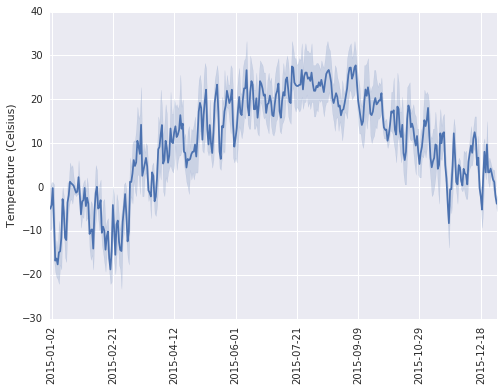

In [9]:
# Plot the average value
ax = (0.5*(wx['tmin']+wx['tmax'])).plot()
x = np.arange(len(wx.date))
palette = sns.color_palette()
ax.fill_between(x, wx['tmin'].values, wx['tmax'].values, alpha=.2, color=palette.pop(0))
ax.set_ylabel("Temperature (Celsius)")
import matplotlib.ticker as plticker
junk = plt.xticks(x[1::50], wx['date'].values[1::50], rotation='vertical')

In [11]:
airwx = bq.Query(airwxquery).to_dataframe()
airwx[:5]

,wx_date,wx_prcp,f_departure_delay,f_arrival_airport
0,2005-04-01,3.8,-4.0,DCA
1,2005-04-02,0.8,-5.0,DCA
2,2005-04-03,0.0,20.0,DCA
3,2005-04-04,0.0,-5.0,DCA
4,2005-04-05,0.0,-3.0,DCA


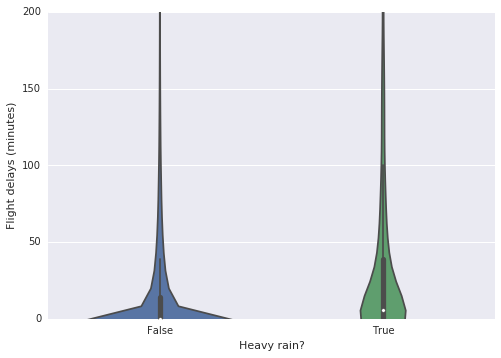

In [12]:
rainyday = airwx.wx_prcp > 25.4 # 1 inch of rain
ax = sns.violinplot(x=rainyday, y=airwx.f_departure_delay)
ax.set_ylim(0, 200)
ax.set_xlabel('Heavy rain?')
ax.set_ylabel('Flight delays (minutes)')

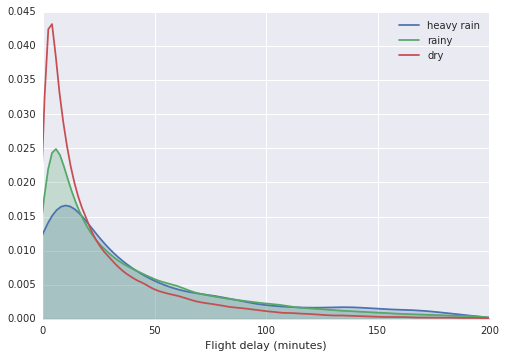

In [13]:
limited = airwx[airwx.f_departure_delay > 0]
limited = limited[limited.f_departure_delay < 200]
heavy = limited.wx_prcp > 25.4 # 1 inch of rain
rainy = limited.wx_prcp > 0
ax = sns.kdeplot(limited.f_departure_delay[heavy], shade=True, label='heavy rain')
ax = sns.kdeplot(limited.f_departure_delay[rainy], shade=True, label='rainy')
ax = sns.kdeplot(limited.f_departure_delay[np.logical_not(rainy)], shade=False, label='dry')
ax.set_xlim(0,200)
ax.set_xlabel('Flight delay (minutes)')